### Rapidly Exploring Random Trees

In [1]:
import numpy as np
import networkx as nx # handle tree
import shapely as sp # handle polygon
from shapely import Polygon,LineString,Point # handle polygons
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("networkx version:[%s]"%(nx.__version__))
print ("shapely version:[%s]"%(sp.__version__))

networkx version:[3.0]
shapely version:[2.0.1]


### `RRT` Class

In [2]:
class RapidlyExploringRandomTreesClass(object):
    """
        Rapidly-Exploring Random Trees (RRT) Class
    """
    def __init__(self,name,point_min=np.array([-1,-1]),point_max=np.array([+1,+1]),
                 steer_len_max=0.1,norm_ord=2):
        """
            Initialize RRT object
        """
        self.name          = name
        self.point_min     = point_min
        self.point_max     = point_max
        self.point_root    = None
        self.point_goal    = None
        self.dim           = len(self.point_min)
        self.steer_len_max = steer_len_max # maximum steer length
        self.norm_ord      = norm_ord      # norm order (2, inf, ... )
        self.tree          = None
        
    def reset(self):
        """
            Reset
        """
        if self.tree is not None:
            self.tree.clear()
        
    def init_tree(self,point_root=None,point_goal=None):
        """
            Initialize Tree
        """
        self.reset()
        self.tree = tree = nx.DiGraph(name=self.name) # directed graph
        self.tree.add_node(0)
        if point_root is None:
            self.point_root = np.zeros(self.dim)
        else:
            self.point_root = point_root
        self.tree.update(nodes=[(0,{'point':self.point_root,'cost':0.0})])
        if point_goal is not None:
            self.point_goal = point_goal
        
    def set_goal(self,point_goal):
        """
            Set Goal
        """
        self.point_goal = point_goal
        
    def add_node(self,point=None,cost=None,node_parent=None):
        """
            Add node to tree
        """
        node_new = self.get_n_node()
        self.tree.add_node(node_new)
        if point is not None:
            self.tree.update(
                nodes=[(node_new,{'point':point})]
            )
        if cost is not None:
            self.tree.update(
                nodes=[(node_new,{'cost':cost})]
            )
        if node_parent is not None:
            self.tree.add_edge(node_parent,node_new)
            
    def get_n_node(self):
        """
            Get number of nodes
        """
        return self.tree.number_of_nodes()
        
    def get_node_nearest(self,point):
        """
            Get nearest node
        """
        distances = [
            self.get_dist_to_node(node=node,point=point)
            for node in self.tree.nodes
        ]
        node_nearest = np.argmin(distances)
        return node_nearest
    
    def get_node_point(self,node):
        """
            Get node point
        """
        return self.tree.nodes[node]['point']
    
    def get_node_cost(self,node):
        """
            Get node cost
        """
        return self.tree.nodes[node]['cost']
    
    def get_dist(self,point1,point2):
        """
            Get distance
        """
        return np.linalg.norm(point1-point2,ord=self.norm_ord)
    
    def get_dist_to_node(self,node,point):
        """
            Get distance from node to point
        """
        return self.get_dist(self.tree.nodes[node]['point'],point)
    
    def get_dist_to_goal(self):
        """
            Get distance from tree to goal
        """
        node_nearest = self.get_node_nearest(self.point_goal)
        dist_goal = self.get_dist_to_node(node=node_nearest,point=self.point_goal)
        return dist_goal
    
    def sample_point(self):
        """
            Sample point
        """
        point_range = self.point_max-self.point_min
        point_rand = self.point_min+point_range*np.random.rand(self.dim)
        return point_rand
    
    def steer(self,node_nearest,point_sample):
        """
            Steer
        """
        # Find the nearest point in the tree
        point_nearest = self.get_node_point(node=node_nearest)
        
        vector = point_sample - point_nearest
        length = np.linalg.norm(vector)
        if length == 0:
            # If the tree already contains 'point_sample', skip this turn
            point_steer,cost_steer = None,None
        else:
            stepsize = min(self.steer_len_max,length)
            point_steer = point_nearest + vector/np.linalg.norm(vector)*stepsize
            cost_nearest = self.get_node_cost(node=node_nearest)
            cost_steer = cost_nearest + \
                self.get_dist_to_node(node=node_nearest,point=point_steer)
        return point_steer,cost_steer
    
    def plot_tree(self,figsize=(6,6),nodesize=50,arrowsize=10,linewidth=1,
                  nodecolor='w',edgecolor='k',xlim=(-1,+1),ylim=(-1,+1),
                  title_str=None,titlefs=10,SKIP_PLT_SHOW=False):
        """
            Plot tree
        """
        if self.dim == 2:
            pos = {node:self.tree.nodes[node]['point'] for node in self.tree.nodes}
        else:
            pos = nx.spring_layout(RRT.tree,seed=0)
        plt.figure(figsize=figsize)
        ax = plt.axes()
        nx.draw_networkx_nodes(
            RRT.tree,pos=pos,node_size=nodesize,node_color=nodecolor,
            linewidths=linewidth,edgecolors=edgecolor,ax=ax)
        nx.draw_networkx_edges(
            RRT.tree,pos=pos,node_size=nodesize,edge_color=edgecolor,
            width=linewidth,arrowstyle="->",arrowsize=arrowsize,ax=ax)
        ax.tick_params(left=True,bottom=True,labelleft=True,labelbottom=True)
        ax.set(xlim=xlim,ylim=ylim)
        if title_str is None:
            title_str = "Tree of [%s]"%(self.name)
        plt.title(title_str,fontsize=titlefs)
        if not SKIP_PLT_SHOW:
            plt.show()
        
print ("Ready.")

Ready.


### Uitl

In [3]:
def is_point_in_polygon(point,polygon):
    """
        Is the point inside the polygon
    """
    if isinstance(point,np.ndarray):
        point_check = Point(point)
    else:
        point_check = point
    return sp.contains(polygon,point_check)
def is_point_feasible(point,obs_list):
    """
        Is the point feasible w.r.t. obstacle list
    """
    result = is_point_in_polygon(point,obs_list) # is the point inside each obstacle?
    if sum(result) == 0:
        return True
    else:
        return False
def is_point_to_point_connectable(point1,point2,obs_list):
    """
        Is the line connecting two points connectable
    """
    result = sp.intersects(LineString([point1,point2]),obs_list)
    if sum(result) == 0:
        return True
    else:
        return False
print ("Ready.")

Ready.


### Instantiate RRT

In [4]:
RRT = RapidlyExploringRandomTreesClass(
    name='RRT-2D',point_min=np.array([-1,-1]),point_max=np.array([+1,+1]),
    steer_len_max=0.1,norm_ord=np.inf)
print ("[%s] instantiated."%(RRT.name))

[RRT-2D] instantiated.


In [5]:
# Set obstacles
obs_list = []
obs_list.append(Polygon([(0.25,0.5),(0.25,-0.5),(0.5,-0.5),(0.5,0.5)]))
obs_list.append(Polygon([(0.5,0.5),(-0.5,0.5),(-0.5,0.25),(0.5,0.25)]))
print ("Ready.")

Ready.


### Loop

In [6]:
RRT.init_tree(point_root=np.zeros(RRT.dim),point_goal=np.array([0.7,0.8]))
while RRT.get_n_node() <= 500:
    # Random sampling
    if np.random.rand() <= 0.1: # goal bias rate
        point_sample = RRT.point_goal
    else:
        point_sample = RRT.sample_point()
    if not is_point_feasible(point_sample,obs_list):
        continue
    # Get nearest node
    node_nearest  = RRT.get_node_nearest(point=point_sample)
    point_nearest = RRT.get_node_point(node=node_nearest)
    # Steering
    point_steer,cost_steer = RRT.steer(
        node_nearest=node_nearest,point_sample=point_sample)
    """ Add node if possible
        1. 'point_steer' is feasible
        2. 'point_nearest' and 'point_steer' is connectable
    """
    if is_point_feasible(point_steer,obs_list) \
        and is_point_to_point_connectable(point_nearest,point_steer,obs_list):
        RRT.add_node(point=point_steer,cost=cost_steer,node_parent=node_nearest)
    # Terminate condition
    dist_to_goal = RRT.get_dist_to_goal()
    if dist_to_goal < 1e-6:
        print ("Goad reached. n_node:[%d] dist_to_goal:[%.4f]"%
               (RRT.get_n_node(),dist_to_goal))
        break
print ("Done.")

Goad reached. n_node:[248] dist_to_goal:[0.0000]
Done.


### Plot

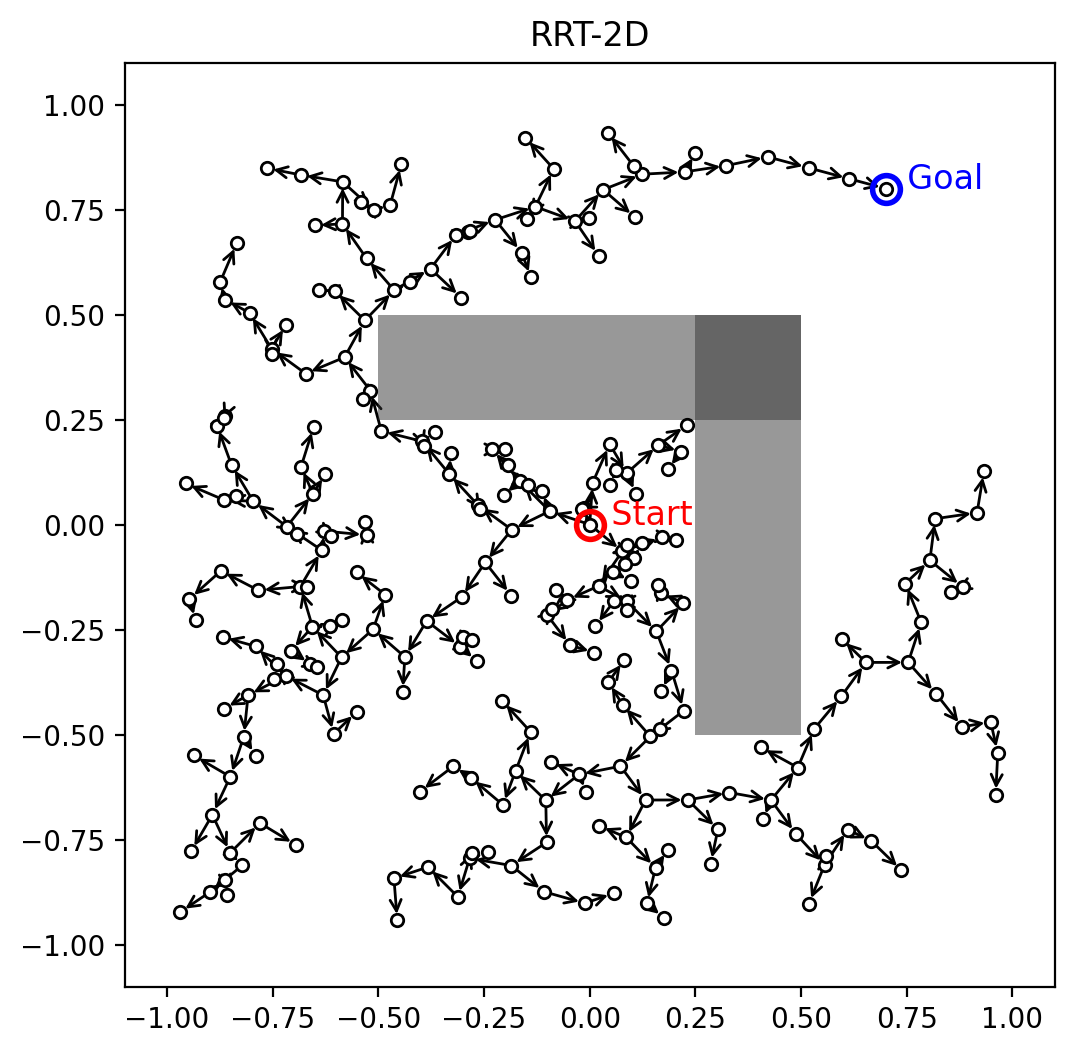

In [7]:
RRT.plot_tree(figsize=(6,6),nodesize=20,arrowsize=10,linewidth=1,
              nodecolor='w',edgecolor='k',xlim=(-1.1,1.1),ylim=(-1.1,1.1),
              title_str='%s'%(RRT.name),titlefs=12,SKIP_PLT_SHOW=True)
for obs in obs_list:
    plt.fill(*obs.exterior.xy,fc=[0.2,0.2,0.2,0.5],ec='none')
plt.plot(RRT.point_root[0],RRT.point_root[1],'o',mfc='none',mec='r',ms=10,mew=2)
plt.text(RRT.point_root[0],RRT.point_root[1],'  Start',color='r',fontsize=12)
plt.plot(RRT.point_goal[0],RRT.point_goal[1],'o',mfc='none',mec='b',ms=10,mew=2)
plt.text(RRT.point_goal[0],RRT.point_goal[1],'  Goal',color='b',fontsize=12)
plt.show()